In [4]:
# Initialization boilerplate
from typing import *

import os
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core
import pandas as pd
import text_extensions_for_pandas as tp
import urllib

import ray
import spacy
import multiprocessing
import time
import threading
import matplotlib.pyplot as plt

api_key = os.environ.get("IBM_API_KEY")
service_url = os.environ.get("IBM_SERVICE_URL")  

import market_intelligence

# Part 6: Additional bonus content

Pipeline for reference:
![First version of our processing pipeline](images/pipeline_v1.png)

This extra code adds monitoring to the Ray processing pipeline from Part 5. This monitoring code lets us visualize the processing timeline for every document that runs through the Ray application.

In [5]:
import market_intelligence as mi
articles = mi.maybe_download_articles()
articles

,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


## Adding monitoring

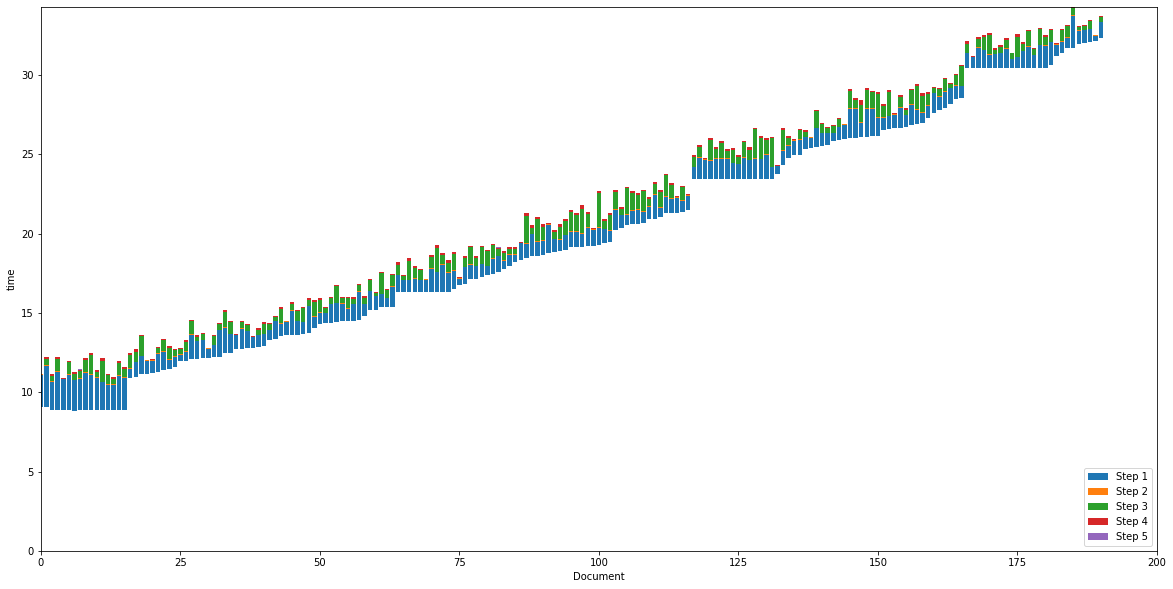

In [51]:
use_standard = True

if use_standard:
    nlu_api_key = os.environ.get("STANDARD_API_KEY")
    nlu_service_url = os.environ.get("STANDARD_SERVICE_URL")  
    nlu_concurrency = 32
    nlu_rate = 100.0
else:
    nlu_api_key = api_key
    nlu_service_url = service_url
    nlu_concurrency = 4
    nlu_rate = 4.0


@ray.remote
class StatusActor:
    def __init__(self, event_names: List[str]):
        # Key is event type, value is list of tuple of doc_id, timestamp
        self._events = {
            name: [] for name in event_names
        }  # type: Dict[str, List[Tuple[int, float]]]
        self._start_time = time.time()
        
    def record_event(self, event_type: str, doc_id: int, timestamp: float):
        if event_type not in self._events:
            raise ValueError(f"Unknown event type '{event_type}'")
        events_list = self._events[event_type]
        events_list.append((doc_id, timestamp - self._start_time))
        
    def doc_status(self) -> pd.DataFrame:
        # Create a 2-column dataframe of [doc_id, timestamp] for each event type
        to_join = [
            pd.DataFrame(evts, columns=["doc_id", name])
            for name, evts in self._events.items()
        ]
        
        # Outer-join all the 2-column dataframes.
        result = pd.DataFrame({"doc_id": pd.Series([], dtype=int)})
        for df in to_join:
            result = result.merge(df, how="outer")
    
        return result
        

@ray.remote
class NLUClientActor(mi.RateLimitedActor):
    """
    Threaded actor to handle multiple simulatenous requests to the IBM Watson
    Natural Language Understanding service while respecting an upper bound on the
    number of requests per second.
    """
    def __init__(self, requests_per_sec: float, 
                 api_key: str, service_url: str):
        super().__init__(requests_per_sec)
        # One instance of the Python API for all threads
        self._nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(
            version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
        self._nlu_api.set_service_url(service_url)
    
    def process_internal(self, doc_html: str) -> Any:
        return mi.extract_named_entities_and_semantic_roles(doc_html, self._nlu_api)
    
@ray.remote
class ParserModelActor(object):
    def __init__(self, spacy_model_name: str, nlu_client: NLUClientActor, status: StatusActor):
        self._language_model = spacy.load(spacy_model_name)
        self._nlu_client = nlu_client
        self._status = status

    def steps_1_through_4(self, doc_id: int, doc_html: str) -> pd.DataFrame:
        self._status.record_event.remote("step_0", doc_id, time.time())
        step_1_results = ray.get(self._nlu_client.process.remote(doc_html))
        self._status.record_event.remote("step_1", doc_id, time.time())
        
        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)
        self._status.record_event.remote("step_2", doc_id, time.time())
        
        step_3_results = mi.perform_targeted_dependency_parsing(
                                                       step_2_results["person"],
                                                       self._language_model)
        
        self._status.record_event.remote("step_3", doc_id, time.time())
        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        
        self._status.record_event.remote("step_4", doc_id, time.time())
        return step_4_results


num_cpus = multiprocessing.cpu_count()

status = StatusActor.remote([f"step_{i}" for i in range(6)])

# The blog version of this code listing should only show how the next line changes.
nlu_client = NLUClientActor.options(max_concurrency=nlu_concurrency).remote(
    nlu_rate, nlu_api_key, nlu_service_url)

    
actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf", nlu_client, status)
                            for i in range(num_cpus)])
    






# Fancy progress bar
def draw_metrics():
    metrics = ray.get(status.doc_status.remote())
    plt.figure(figsize=(20,10))
    if len(metrics.index) > 0:
        for step_num in range(1, 5):
            plt.bar(
                metrics["doc_id"], 
                metrics[f"step_{step_num}"] - metrics[f"step_{step_num - 1}"], 
                bottom=metrics[f"step_{step_num - 1}"],
                   label=f"Step {step_num}")
        plt.legend(loc="lower right")
        
    plt.xlabel("Document")
    plt.ylabel("time")
    plt.ylim(bottom=0)
    plt.xlim(0, 200)
    clear_output(wait=True)
    plt.show()

# display(progress_bar)

articles_used = articles  #.iloc[:10]

# Enqueue all the documents at once.
# If we had more documents, we would enqueue them in batches.
for row in articles_used["html"].iteritems():
    actors.submit(lambda actor, value: actor.steps_1_through_4.remote(value[0], value[1]), row)

# Retrieve results.
dataframes_to_stack = []
last_draw_time = time.time()
while actors.has_next():
    # Fetch everything that's available before moving to redraw
    try:
        while actors.has_next():
            dataframes_to_stack.append(actors.get_next_unordered(timeout=0.1))
    except TimeoutError:
        pass
    
    if time.time() - last_draw_time > 5.0:
        draw_metrics()
        last_draw_time = time.time()
    
# Draw once more to catch anything that finished since the last redraw
draw_metrics()
step_5_results = pd.concat(dataframes_to_stack)

In [ ]:
# Set up a progress bar
# import ipywidgets
# from IPython.display import display
# from IPython.display import clear_output
# progress_bar = ipywidgets.IntProgress(0, 0, len(articles_used.index),
#                                       description="Loading models...",
#                                       layout=ipywidgets.Layout(width="100%"),
#                                       style={"description_width": "12%"})

#     num_processed = len(metrics.index)
    
#     progress_bar.value = num_processed
#     progress_bar.description = f"{num_processed} of {len(articles_used.index)} documents"
    

In [12]:
# Retrieve the current metrics
metrics = ray.get(status.doc_status.remote())
#print(f"Have {len(dataframes_to_stack)} results and metrics for {len(metrics.index)} documents")
metrics

,doc_id,start,step_1,step_2,step_3,step_4,step_5
0,2,8.588857,10.265581,10.304621,10.572633,10.650385,10.650832
1,6,8.748375,11.783505,11.825064,12.107271,12.188425,12.188617
2,13,8.770793,11.892379,11.935723,12.289809,12.350040,12.350332
3,11,8.771215,18.240676,18.310577,19.314143,19.453234,19.453433
4,5,8.788590,11.541384,11.580417,12.150094,12.222909,12.223170
...,...,...,...,...,...,...,...
186,186,52.795554,54.451044,54.473206,54.696350,54.765060,54.765362
187,187,53.201159,54.354213,54.379509,54.609737,54.688995,54.689275
188,188,53.339607,55.744494,55.770474,56.355964,56.424839,56.425165
189,189,53.402546,55.493339,55.514810,55.516189,55.549061,55.549327


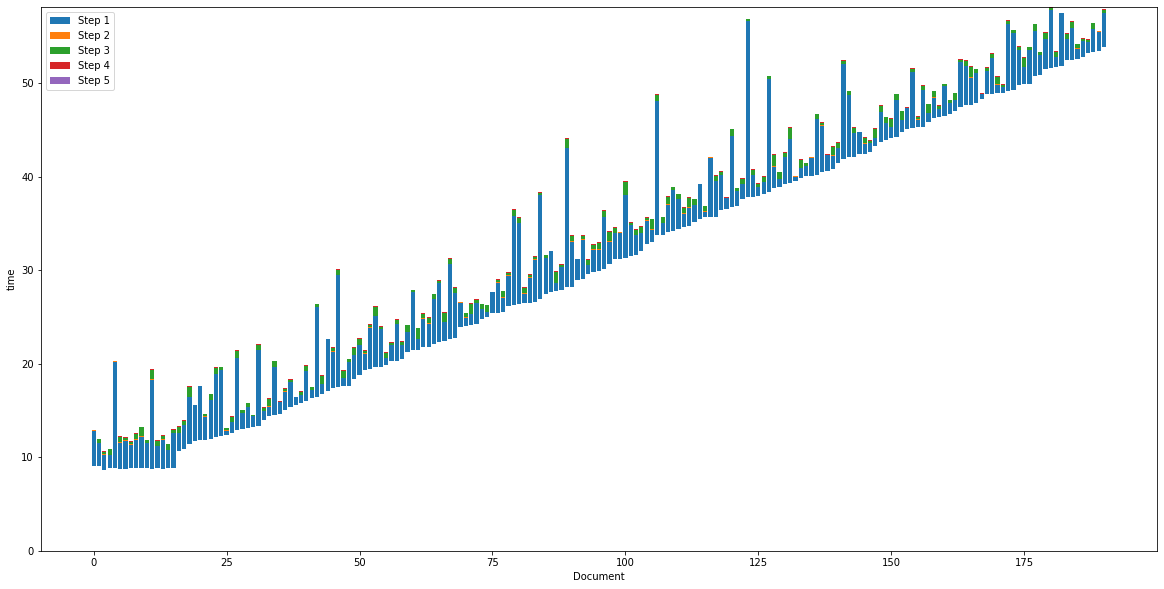

In [13]:
metrics = ray.get(status.doc_status.remote())

plt.figure(figsize=(20,10))

# Rename start -> step_0 to simplify the loop that follows
metrics = metrics.rename(columns={"start": "step_0"})
for step_num in range(1, 6):
    plt.bar(metrics["doc_id"], metrics[f"step_{step_num}"] - metrics[f"step_{step_num - 1}"], bottom=metrics[f"step_{step_num - 1}"],
           label=f"Step {step_num}")

plt.xlabel("Document")
plt.ylabel("time")
plt.ylim(bottom=0)
plt.legend(loc="upper left")
plt.show()

In [ ]:
%matplotlib inline 

from IPython.display import clear_output

# Simulate processing
metrics = ray.get(status.doc_status.remote())

# Rename start -> step_0 to simplify the loop that follows
metrics = metrics.rename(columns={"start": "step_0"})



for step in range(100):
    #print(f"step {step}")
    
    cur_metrics = metrics.iloc[:step]
    
    plt.figure(figsize=(20,10))
    for step_num in range(1, 6):
        plt.bar(
            cur_metrics["doc_id"], 
            cur_metrics[f"step_{step_num}"] - cur_metrics[f"step_{step_num - 1}"], 
            bottom=cur_metrics[f"step_{step_num - 1}"],
               label=f"Step {step_num}")
    plt.xlabel("Document")
    plt.ylabel("time")
    plt.ylim(bottom=0)
    plt.xlim(0, 200)
    plt.legend(loc="lower right")
    clear_output(wait=True)
    plt.show()
    
    #time.sleep(0.5)
    
    
    
    

In [ ]:
%matplotlib inline 

import numpy as np
#import matplotlib.pyplot as plt
from IPython.display import clear_output


n = 10
a = np.zeros((n, n))
plt.figure()

for i in range(n):
    plt.imshow(a)
    plt.show()
    a[i, i] = 1
    clear_output(wait=True)